# Introduction

In this tutorial, we will learn to model online forums. 

In [3]:
devtools::load_all()
#install.packages("igraph")

Loading genthreads
Loading required package: iterators

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last


Attaching package: ‘igraph’

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Installing package into ‘/home/alumbreras/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)


## Vector representation of a tree

We will first learn how to represent the structure and dynamics of an online conversations in a very simple way. We will create its **parents vector**. The parents vector is a vector $\boldsymbol{\pi} = (\pi_1,...,\pi_2)$ where $\pi_t$ contains the parent of node $t$. Our package contains a function that plots the tree corresponding to a parents vector. For the above tree, we would have:

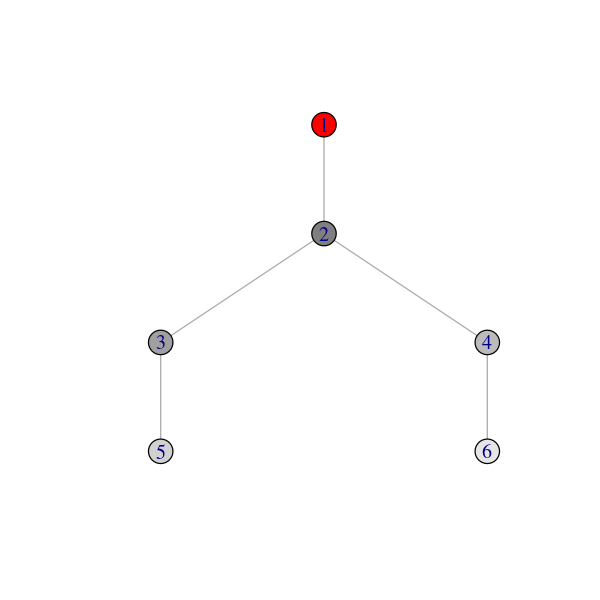

In [27]:
options(repr.plot.width=5, repr.plot.height=5)

# Vector representation
parents <- c(1,2,2,3,4)

# Plot it as a tree
gtree <- parents_to_tree(parents)
V(gtree)$color <- gray.colors(vcount(gtree))
V(gtree)[1]$color <- "red"
gtree.un <- as.undirected(gtree)
la = layout_as_tree(gtree.un, mode='out', root=1)
plot(gtree.un, layout = la, vertex.size=15)

## A real conversation

We will first load some conversations in Reddit to see what do they look like

In [28]:
data("df.posts.france")

df.thread <- df.posts %>%
  group_by(thread) %>% arrange(date) %>% filter(n()>10) %>%
  mutate(pi = as.integer(match(parent, unique(parent))-1)) %>% 
  ungroup %>%
  arrange(thread, date)

parents <- df.thread %>% filter(pi > 0) %>% group_by(thread) %>%  
  do(thread=.$pi) %>%  ungroup()  %>%
  lapply(function(x) {(x)})
parents <- parents[[1]]

cat('Threads:', length(parents))

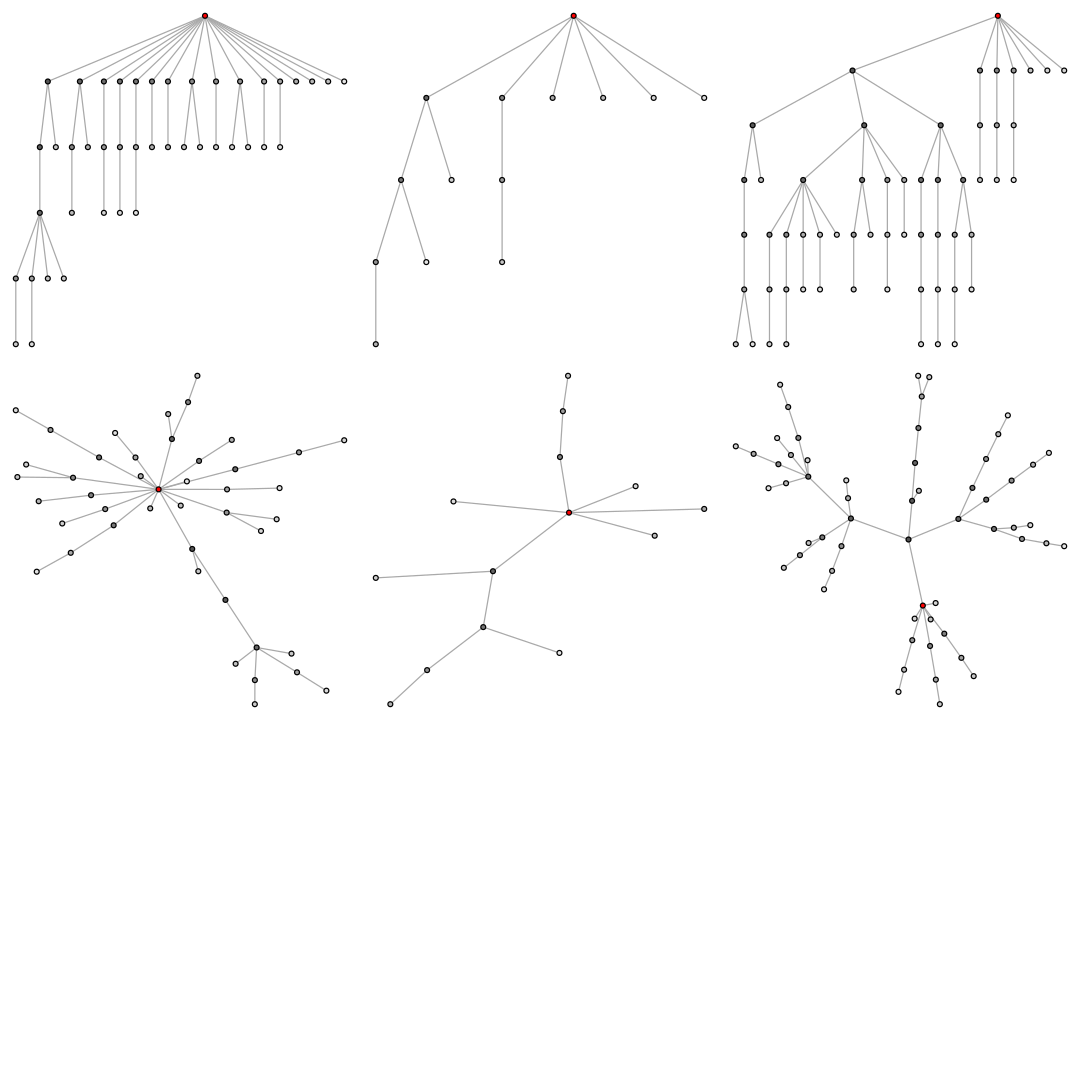

In [50]:
options(repr.plot.width=9, repr.plot.height=9)

# Plot some threads in tree and graph representations

par(mfrow = c(3,3))
plot.tree(parents[[1]])
plot.tree(parents[[2]])
plot.tree(parents[[3]])

plot.tree.nicely(parents[[1]])
plot.tree.nicely(parents[[2]])
plot.tree.nicely(parents[[3]])

## Generating synthetic conversations with a growth model

Our conversation model is as follows:
$$
p(\pi_t) \propto d^\alpha + b\beta + \tau^t
$$

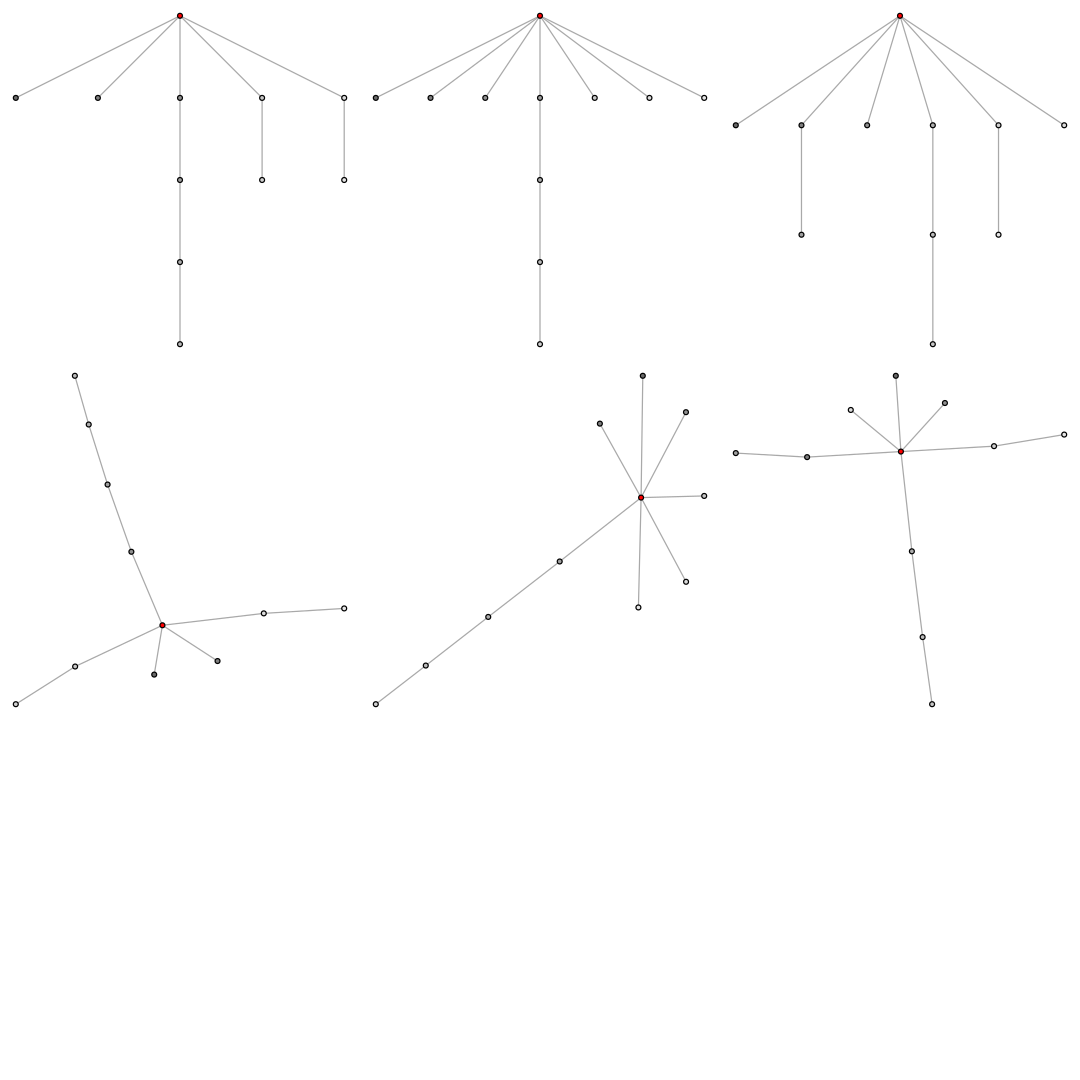

In [60]:
options(repr.plot.width=9, repr.plot.height=9)

alpha <- 0.0
beta <- 1
tau <- 0.2
ntrees <- 20

parents <- replicate(ntrees,
                     gen.parentsvector.Gomez2013(n, alpha, beta, tau), 
                     simplify = FALSE)

par(mfrow = c(3,3))
plot.tree(parents[[1]])
plot.tree(parents[[2]])
plot.tree(parents[[3]])

plot.tree.nicely(parents[[1]])
plot.tree.nicely(parents[[2]])
plot.tree.nicely(parents[[3]])

## Find model parameters that fit real conversations 

Now we have a growth model. We can fit its parameters to the real threads.

In [ ]:

# Estimate paremeters ----------------------------------------------------------

# Store in dataframe format. 
# Each line contains the post id, the chosen parent
# and the features of its parent (popularity, lag, root) at the 
# moment (t) of that choice.
df.trees <- all_parents_to_dataframe(parents)        

# Grid search of one parameter given the other two 
# This is useful to see the shape of the likelihood around the MLE.


# Estimate alpha, beta, tau parameters
res <- estimation_Gomez2013(df.trees = df.trees, params=list(alpha=0.5, beta=0.6, tau=0.5))

# Generate threads with the estimated parameters
parents_hat <- replicate(ntrees,
                         gen.parentsvector.Gomez2013(n, res$alpha, res$beta, res$tau), 
                         simplify = FALSE)

# Compare structural properties ------------------------------------------------

# Degree distribution
df.degrees     <- struct_degree_distribution(parents)
df.degrees_hat <- struct_degree_distribution(parents_hat)
df.degrees$cumprob     <- cumsum(df.degrees$frequency/sum(df.degrees$frequency))
df.degrees_hat$cumprob <- cumsum(
                           df.degrees_hat$frequency/sum(df.degrees_hat$frequency)
                          )            

df.degrees$data     <- 'real'
df.degrees_hat$data <- 'estimated'
df.degrees <- bind_rows(df.degrees, df.degrees_hat)
ggplot(df.degrees, aes(x=degree, y = cumprob)) + 
  geom_point() +
  scale_y_log10() +
  facet_grid(.~data) +
  theme_bw() +
  ylab('CPF')

# Subtree size distribution
df.subtrees     <- struct_subtree_size_distribution(parents)
df.subtrees_hat <- struct_subtree_size_distribution(parents_hat)
df.subtrees$cumprob     <- cumsum(df.subtrees$frequency/sum(df.subtrees$frequency))
df.subtrees_hat$cumprob <- cumsum(
                          df.subtrees_hat$frequency/sum(df.subtrees_hat$frequency)
                        )        

df.subtrees$data     <- 'real'
df.subtrees_hat$data <- 'estimated'
df.subtrees <- bind_rows(df.subtrees, df.subtrees_hat)
ggplot(df.subtrees, aes(x=degree, y = cumprob)) + 
  geom_point() +
  scale_y_log10() +
  facet_grid(.~data) +
  theme_bw() +
  ylab('CPF')


# Size vs Depth
df.sizedepth     <- struct_size_depth(parents)
df.sizedepth_hat <- struct_size_depth(parents_hat)

df.sizedepth$data     <- 'real'
df.sizedepth_hat$data <- 'estimated'
df.sizedepth <- bind_rows(df.sizedepth, df.sizedepth_hat)
ggplot(df.sizedepth, aes(x=size, y = depth)) + 
  geom_point() +
  #scale_y_log10() +
  facet_grid(.~data) +
  theme_bw() +
  xlab(size) + ylab('depth')


## Compare structural properties